In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import torch
from hessian_eigenthings import compute_hessian_eigenthings
import torch.nn as nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
num_samples = 100
num_features = 20
torch.manual_seed(0)
X = torch.normal(0, 1, size=(num_samples, num_features))
y = torch.normal(0, 1, size = (num_samples,1))

In [7]:
class Network(nn.Module):

    def __init__(self):
        
        super().__init__()

        self.fc1 = nn.Linear(20, 10, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 5, bias=False)
        self.fc3 = nn.Linear(5, 1, bias=False)

        
    def forward(self,x):

        x = self.fc1(x) 
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

In [16]:
linear_model = Network()
criterion = torch.nn.MSELoss()
optimizer = optim.SGD(linear_model.parameters(), lr=0.0045, momentum=0.9)
trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X, y), batch_size=10,shuffle=True)

In [17]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = linear_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
#         if i % 10 == 0:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.5f}')
#             running_loss = 0.0

    if epoch%20 == 0:
        PATH = 'linear_model_v2_iter' + str(epoch)
        torch.save(linear_model.state_dict(), PATH)

    print(f'epoch: {epoch+1}, loss:{running_loss/10}')

print('Finished Training')

epoch: 1, loss:0.84967300593853
epoch: 2, loss:0.8432710617780685
epoch: 3, loss:0.8334533661603928
epoch: 4, loss:0.826419734954834
epoch: 5, loss:0.8191600739955902
epoch: 6, loss:0.8124270051717758
epoch: 7, loss:0.803206767141819
epoch: 8, loss:0.7947927325963974
epoch: 9, loss:0.7832286268472671
epoch: 10, loss:0.7742424786090851
epoch: 11, loss:0.7519905060529709
epoch: 12, loss:0.7364697545766831
epoch: 13, loss:0.7134256035089492
epoch: 14, loss:0.6881585210561753
epoch: 15, loss:0.6639719575643539
epoch: 16, loss:0.6428852468729019
epoch: 17, loss:0.6216584950685501
epoch: 18, loss:0.5989160254597664
epoch: 19, loss:0.5806975819170475
epoch: 20, loss:0.5592657372355461
epoch: 21, loss:0.5412370651960373
epoch: 22, loss:0.5166527092456817
epoch: 23, loss:0.49376378357410433
epoch: 24, loss:0.4685893028974533
epoch: 25, loss:0.4482808604836464
epoch: 26, loss:0.42240573465824127
epoch: 27, loss:0.397130174934864
epoch: 28, loss:0.37422932088375094
epoch: 29, loss:0.3469558879733

In [19]:
num_eigenthings = 30

eigenvals_dict = {}
eigenvecs_dict = {}

for i in range(0, 100, 20):
    
    PATH = 'linear_model_v2_iter' + str(i)
    linear_model = Network()
    linear_model.load_state_dict(torch.load(PATH))
    eigenvals, eigenvecs = compute_hessian_eigenthings(linear_model, trainloader,criterion, num_eigenthings, use_gpu=False)  
    eigenvals_dict[i] = eigenvals
    eigenvecs_dict[i] = eigenvecs
    h = np.matmul(np.matmul(eigenvecs.T, np.diag(eigenvals)), eigenvecs)
    

 [=============================================================>...]  Step: 16ms | Tot: 338ms | power iter error: 0.03 20/20 
 [=============================================================>...]  Step: 16ms | Tot: 316ms | power iter error: 0.00 20/20 .................]  Step: 16ms | Tot: 66ms | power iter error: 0.00 5/20 ...................]  Step: 16ms | Tot: 116ms | power iter error: 0.00 8/20 =====================================>............]  Step: 16ms | Tot: 266ms | power iter error: 0.00 17/20 
 [=============================================================>...]  Step: 16ms | Tot: 322ms | power iter error: 0.00 20/20 
 [=============================================================>...]  Step: 17ms | Tot: 319ms | power iter error: 0.00 20/20 ................]  Step: 16ms | Tot: 151ms | power iter error: 0.00 10/20 ============>.........................]  Step: 16ms | Tot: 201ms | power iter error: 0.00 13/20 ========================>...................]  Step: 16ms | Tot: 234ms

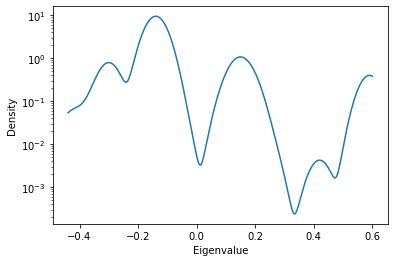

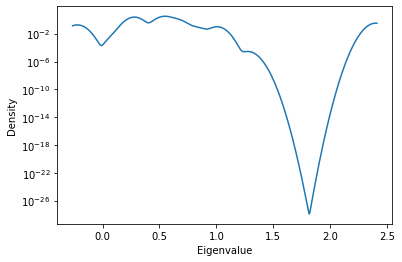

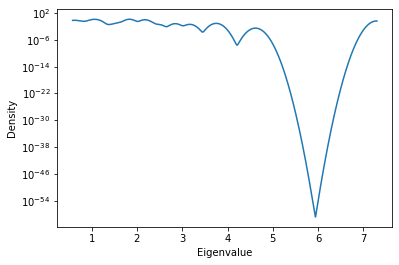

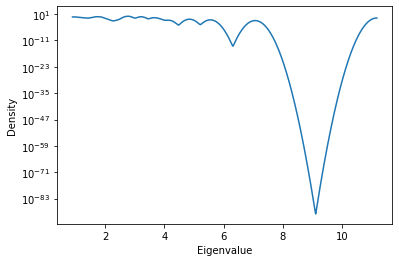

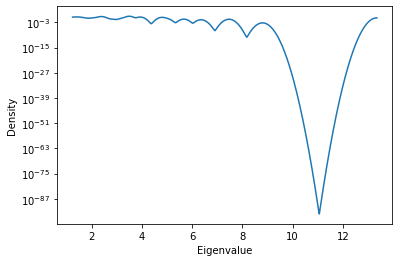

In [20]:
import density as density_lib
def plot(grids, density, label=None):
    
    plt.semilogy(grids, density, label=label)
#     plt.ylim(1e-10, 1e2)
    plt.ylabel("Density")
    plt.xlabel("Eigenvalue")
    plt.show()
    #plt.savefig('fig.jpg')
#     plt.legend()


for i in range(0, 100, 20):

    density, grids = density_lib.tridiag_to_density(eigenvals_dict[i], eigenvecs_dict[i], grid_len=10000, sigma_squared=1e-3)

    plot(grids, density)